# Procrastinate Pro+ app advertising campaign analysis

## Project description 

We have at our disposal a server log with data on visits to the app by new users who registered between 2019-05-01 and 2019-10-27, an upload of their purchases during this period, as well as statistics on the entertainment app's advertising spend. Despite investing heavily in advertising and promotion, the business is making a loss. I need to study how people use the product, when they start buying, how much money each customer brings in, when it pays off, and what factors have an impact on user engagement

We will have to answer the following questions:

- Does advertising aimed at attracting users in general pay for itself? 
- Which devices, countries and advertising channels can have a negative impact on the return on advertising?
- What might be causing the ROI problems? Examine conversion and retention by device, country, advertising channel.

Make conclusions:
- Identify the causes of inefficiencies in user engagement;
- Formulate recommendations for the marketing department to improve app promotion

**Data description** We have 3 dataframes: server log with information about site visits, information about orders, information about marketing costs
**Table visits_log_short*:
- User Id - unique identifier of the user
- Device - user's device category
- Session start - start date and time of the session
- Session End - date and time of the session end
- Channel - identifier of advertising source the user came from
- Region - user's country

*Table orders_log_short*:
- User Id - unique id of the user who placed the order
- Event Dt - date and time of purchase
- Revenue - revenue

*table costs_short*:
- Channel - advertising source ID
- Dt - date
- Costs - costs for this advertising source on this day

 **Table of content**:

[**Step 1.  Data Wrangling**](#ci)

[**Step 2. Define functions to calculate and analyse LTV, ROI, retention and conversion**](#pr)

[**Step 3. Conduct exploratory data analysis**](#da)

[**Step 4. Analyse marketing**](#port)

[**Step 5. Evaluate ROI**](#hch)

[**Step 6. Make conclusions**](#conc)



<a id='ci'></a>
# 1. Data Wrangling

In [1]:
#import libraries
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
#unload the files and name them
visits= pd.read_csv('/datasets/visits_info_short.csv')
orders=pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
#explore visits df
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
#explore orders df
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [5]:
#explore costs df
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [6]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [7]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [8]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [9]:
#standartise names of the columns in df
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
costs.columns = [x.lower().replace(' ', '_') for x in costs.columns.values]

In [10]:
#change the data type
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [11]:
#check if there is any duplicate
visits[visits.duplicated()].sum()

user_id    0.0
region     0.0
device     0.0
channel    0.0
dtype: float64

In [12]:
#check if there is any duplicate
orders[orders.duplicated()].sum()

user_id    0.0
revenue    0.0
dtype: float64

In [13]:
#check if there is any duplicate
costs[costs.duplicated()].sum()

dt         0.0
channel    0.0
costs      0.0
dtype: float64

In [14]:
#check for implicit duplicates
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

**Conclusion** As we see, there are no missing values or duplicates in the dataframes. We brought all column names to snake case and changed the data type in the columns time type for ease of further calculations.

<a id='pr'></a>
# 2. Define functions to calculate and analyse LTV, ROI, retention and conversion


## Function for creating user profiles

In [15]:
def get_profiles(sessions, orders, costs, event_names=[]):

    # find the parameters of the first visits
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # for the cohort analysis, determine the date of the first visit
    # and the first day of the month on which the visit took place
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # count the number of unique users
    # with the same source and date of attraction
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # combine advertising expenditure with the number of users attracted
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # divide the advertising costs by the number of users attracted
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # add the cost of acquisition to the profiles
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # the cost of acquiring organic users is zero
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


## Function to calculate the retention

In [16]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # add the payer column to the dimensions list
    dimensions = ['payer'] + dimensions

    # exclude users who have not survived to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # collecting "raw" data to calculate the retention
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # function for grouping the table according to the desired characteristics
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # get the retention table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time 

## Function to calculate conversion

In [17]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # exclude users who have not survived to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # determine the date and time of the first purchase for each user
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # add purchase data to profiles
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # calculate the Lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # function for grouping the table according to the desired characteristics
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # divide each "cell" in the row by the cohort size
        # and get the conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # get the conversion table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    if 'cohort' in dimensions: 
        dimensions = []

  # get a table of conversion rates
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return result_raw, result_grouped, result_in_time 

## Function for calculating LTV and ROI

In [18]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        
        # combine cohort sizes and revenue table
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes

        # Assemble the dataframe with user data and CAC values, 
        # adding parameters from dimensions

        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # calculate the average CAC for the parameters from the dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # calculate ROI: 
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']

        # in the final table leave cohort sizes, CAC
        # and ROI in the lifetimes that not exceeding the analysis horizon
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    # get LTV and ROI 
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw, 
        result_grouped, 
        result_in_time,
        roi_grouped,
        roi_in_time,
    ) 

In [19]:
# function for smoothing the data frame
def filter_data(df, window):

    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

## Function for visualising retention

In [20]:
def plot_retention(retention, retention_history, horizon, window=7):


    plt.figure(figsize=(15, 10))
    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

   # if the retention table indexes only payer,
    # add a second attribute - cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Paying users retention')

    
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Non paying users retention')

    
    ax3 = plt.subplot(2, 2, 3)
    
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # filter the data and make a graph
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Date of Acquisition')
    plt.title(
        'Trends in retention of paying users on {}day'.format(
            horizon
        )
    )

    
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
   
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Date of Acquisition')
    plt.title(
        'Trends in retention of non paying users on {}day'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

## Function to visualise conversions

In [21]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(15, 5))
    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # first graph - conversion charts
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('User conversion')

    # second graph - conversion rates
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Date of Acquisition')
    plt.title(
        'Trends in conversion on {}day'.format(horizon)
    )

    plt.tight_layout()
    plt.show() 

## Function to visualise LTV and ROI

In [22]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))
    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # first graph - ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    # second graph —  ltv dynamics 
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Date of Acqusition')
    plt.title('User LTV dynamics on the {}th day'.format(horizon))

    # cac dynamics
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)

    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Date of Acqusition')
    plt.title('User CAC dynamics')

    # roi graphs
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='ROI')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    # dynamics roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='ROI')
    plt.xlabel('Date of acqusition')
    plt.title('User ROI dynamics on the {}th day'.format(horizon))

    plt.tight_layout()
    plt.show() 
    
    

<a id='da'></a>
# 3. Exploratory data analysis

Build user profiles. Determine the minimum and maximum date of user engagement.

**Find out**:
- From which countries do visitors come? Which countries produce the most paying users?
- What devices are they using? From which devices are paying users most likely to come?
- Which advertising channels were used to attract users? Which channels bring in the most paying users?

In [23]:
#look closer at the profiles of our users
profiles = get_profiles(visits, orders,costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [24]:
#maximum and minimum date of user acquisition
max_analysis_date=profiles['dt'].max()
min_analysis_date=profiles['dt'].min()
print('min date',min_analysis_date)
print('max date',max_analysis_date)

min date 2019-05-01
max date 2019-10-27


In [25]:
#see how many paying and non-paying users we have in total
profiles.groupby('payer')['user_id'].count()

payer
False    141127
True       8881
Name: user_id, dtype: int64

In [26]:
#a table showing the number of users and the proportion paying from each country
profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'mean'})\
        .rename(columns={'user_id': 'numb_of_u','payer': 'part_paying'})\
        .sort_values(by='part_paying', ascending=False)

,numb_of_u,part_paying
region,,
United States,100002,0.069019
Germany,14981,0.041119
UK,17575,0.039829
France,17450,0.037994


As we can see, we have the most users in the US, which also has the highest percentage of paying users - almost 7%.

In [27]:
#a table showing the number of users and the proportion paying for each device
profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'mean'})\
        .rename(columns={'user_id': 'numb_of_u','payer': 'part_paying'})\
        .sort_values(by='part_paying', ascending=False)

,numb_of_u,part_paying
device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


From the aggregated data, we can see that we are most used by Apple users, and they are also the most paying users.

In [28]:
#a table showing the number of users and the share of paying users for each channel
profiles.groupby('channel').agg({'user_id':'nunique','payer':['sum','mean']})\
    .sort_values(by=('payer','mean'),ascending=False).style.format({('payer','mean'):'{:.2%}'})


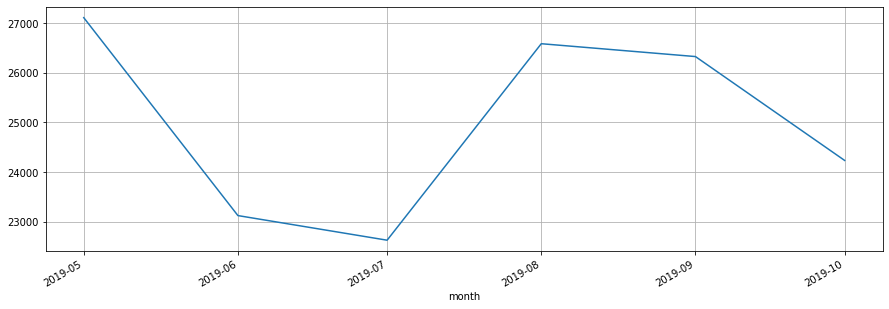

In [29]:
#a table showing the number of users each month
profiles.groupby('month')['user_id'].agg('count').sort_values(ascending=False).plot(figsize=(15, 5), grid=True)
plt.show()

What are the first conclusions? The most important thing is that the conversion into paying users is very low, only every 16 users bring us money and pay for the app, we need to find out why. The USA has the highest number of users and also the highest percentage of paying users, almost 7%, but in Europe the percentage is almost 2 times lower. The most paying users come to us from FaceBoom,AdNonSense and lambdaMediaAds, but they also account for just over 10% of the total flow of registrations. Same for amount of attracted users: that indicator is unstable and went down in June and July and up in upcoming month, we should check it closer

<a id='port'></a>
# 4. Marketing

**Find out:**
- How much money was spent? Total / per source / per month
- How much did it cost on average to attract one customer from each source?

In [30]:
# see how much was spent on marketing in total
round(costs['costs'].sum(),1)

105497.3

In [31]:
#Let's look at costs by channels
report1=costs.pivot_table(index='channel',values='costs',aggfunc='sum').sort_values(by='costs', ascending=False)
report1

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


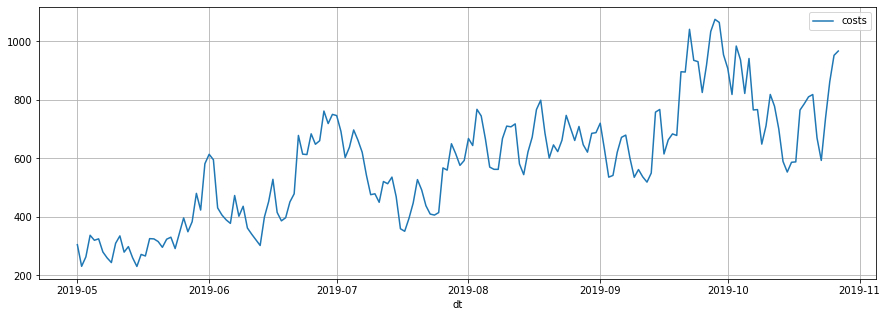

In [32]:
#Let's look at money spent in time
spent_month=costs.pivot_table(index='dt',values='costs',aggfunc='sum').sort_values(by='costs', ascending=False)
spent_month.plot(figsize=(15, 5), grid=True)

plt.show()

In [33]:
#lets see expenditure by channel and date 
report2=costs.pivot_table(index='dt',columns='channel',values='costs',aggfunc='sum').sort_values(by='dt', ascending=False)
report2.head(6)

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
dt,,,,,,,,,,
2019-10-27,35.70,233.2,12.81,4.56,17.75,10.075,588.0,42.0,11.07,12.0
2019-10-26,21.00,272.8,14.28,6.72,14.25,4.550,563.5,40.8,5.67,8.8
2019-10-25,26.25,255.2,14.70,6.24,16.50,7.150,483.0,37.2,7.56,8.8
2019-10-24,21.00,222.2,12.81,5.04,12.50,5.850,402.5,42.0,7.29,6.4
2019-10-23,15.75,178.2,10.71,5.28,13.25,5.525,322.0,31.8,6.48,4.0
2019-10-22,23.10,189.2,11.55,3.36,13.25,6.500,388.5,22.2,5.94,6.4


In [34]:
#See the table by month to see how much was spent on marketing by channel
cost2=costs
cost2['dt']=pd.to_datetime(cost2['dt'])
cost2['month']=cost2['dt'].dt.month
costs = cost2.pivot_table(index='month',columns='channel',values='costs',aggfunc='sum').sort_values(by='month')

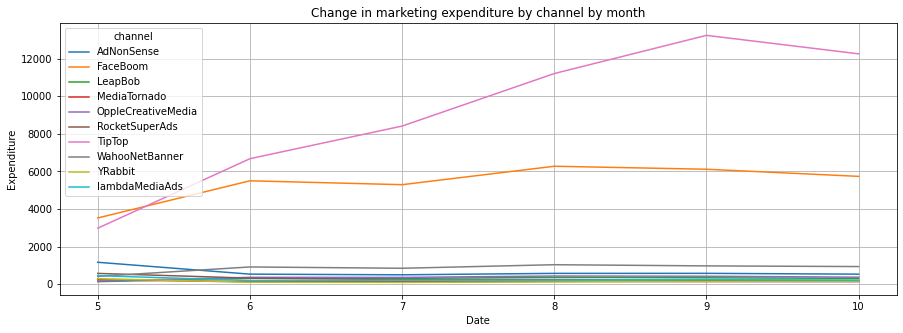

In [35]:
costs.plot(figsize=(15, 5), grid=True)
plt.title('Change in marketing expenditure by channel by month')
plt.ylabel('Expenditure')
plt.xlabel('Date')
plt.show();


During the 5 months of the project, the advertising investment in TipTop increased by a factor of 5.
You can also see that the most money is spent on channels TipTop and Faceboom

In [36]:
# calculate the average CAC per channel
CAC = (profiles.groupby('channel')
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'}).sort_values(by='cac',ascending=False)
        )
CAC

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


In [37]:
#exclude organic users from calculating the average for all channels as they can distort our values
profiles_wo=profiles.query('channel!="organic"')
round(profiles['acquisition_cost'].mean(),2)

0.7

In almost 6 months of the campaign we spent more than 100k, but attracted only 8k paying users. The average cost of attracting one user was 1.13. The most expensive users we got in TipTop - almost 3, while only 19561 users came from TipTop. and we have only attracted 1,561 users. Same FB with an average user price slightly more than 1 brought us nearly 30k users, but it is incomparably low with those who organically found us - 50k users and not a penny spent (yes, their conversion into users is also very low). It seems that our application has problems or we don't know how to buy advertising.

<a id='hch'></a>
# 5. Evaluate ROI

Using LTV and ROI:
- Analyse the overall ROI;
- Analyse advertising ROI by device;
- Analyse advertising ROI by country;
- Analyse advertising ROI by advertising channel.

Describe the problems you found. 

### Analyse the overall return on advertising

In [38]:
#analyse the overall return on advertising and set a time and horizon for the analysis
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

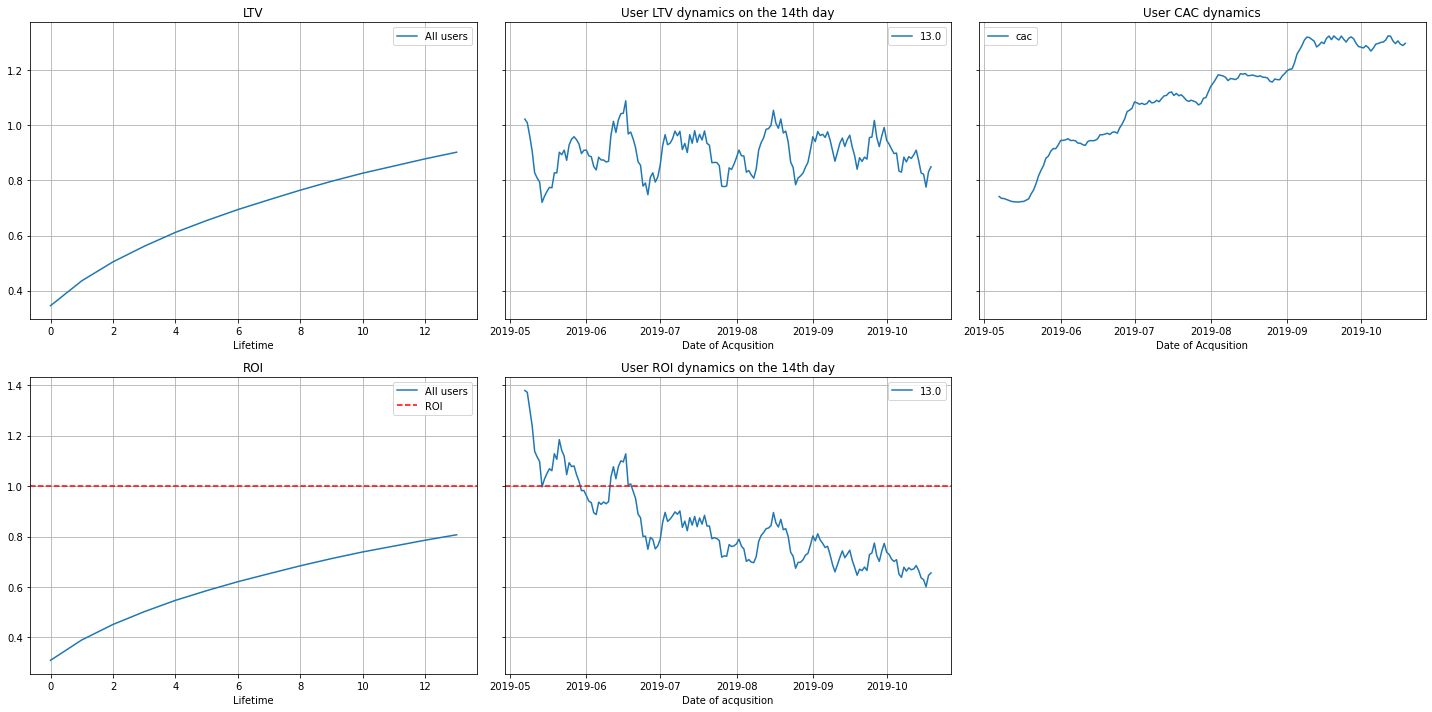

In [39]:
# count LTV and ROI
# exclude organic users from the calculations,
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo, orders, observation_date, horizon_days
)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

The graphs clearly show that

  *advertising is not paying off;*
  
  *CAC is rising and ROI is falling, so we are investing in non-performing ads;*
  
  *LTV is more or less uniform and on day 14 is between 0.8 and 1$

### Analyse ROI and LTV on advertising by device

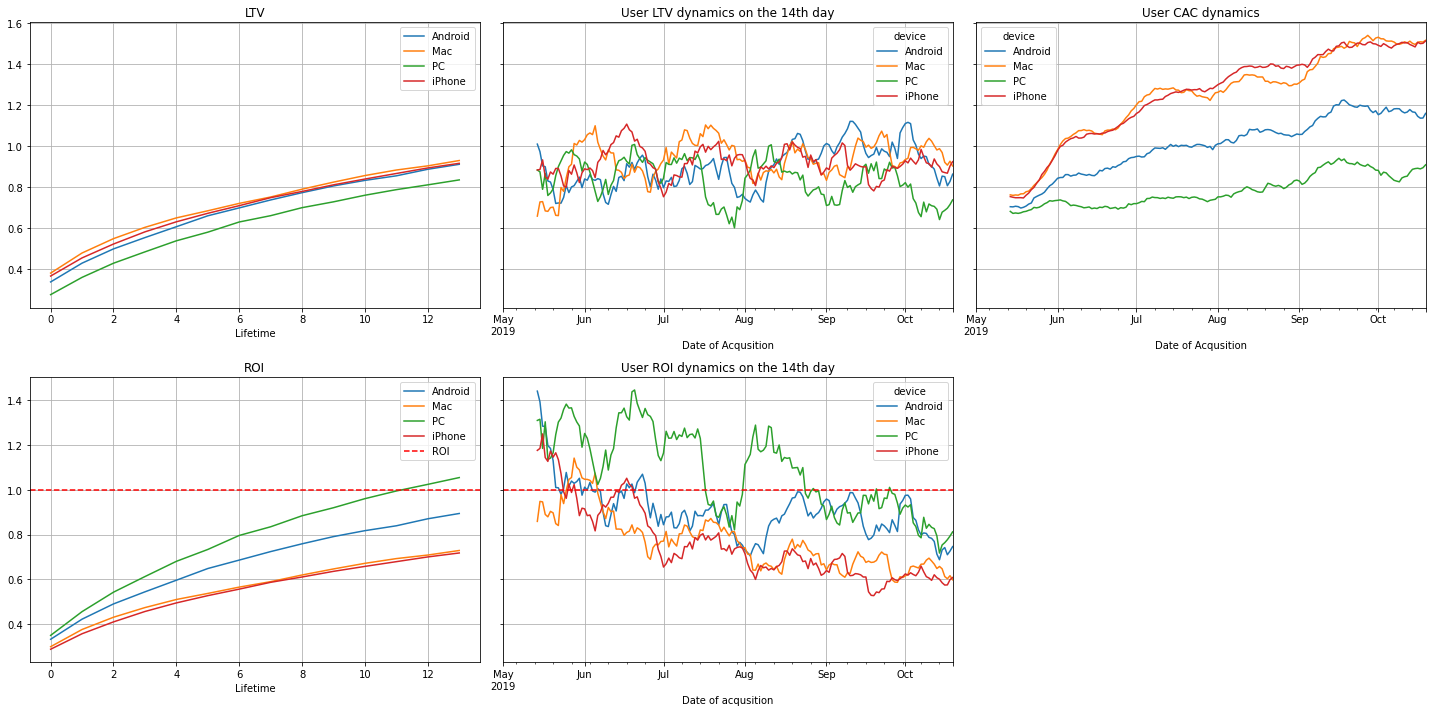

In [40]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

By device, we can see that the dynamics of the cost of attracting users is increasing, especially for Iphones and Macs. 
The ROI for PC users alone is greater than 1 and on day 11 the ROI for Iphones and Macs is at its lowest. For Android this figure is higher, perhaps it is worth paying attention to.


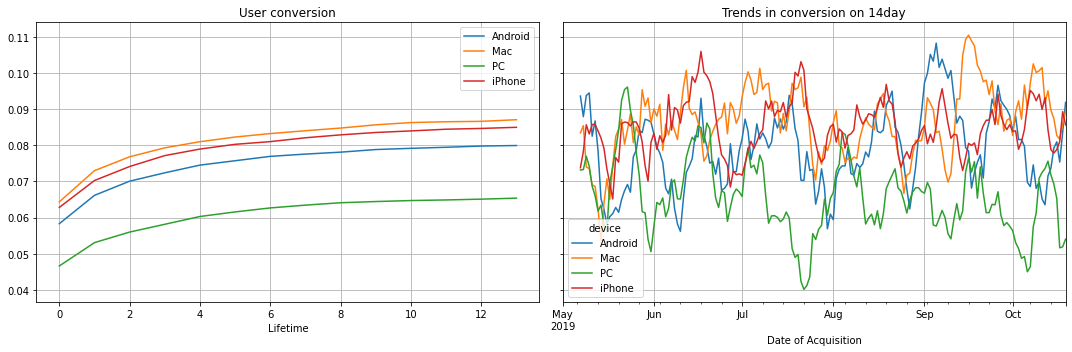

In [41]:
# lets see conversion rates by device
dimensions=['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_wo, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

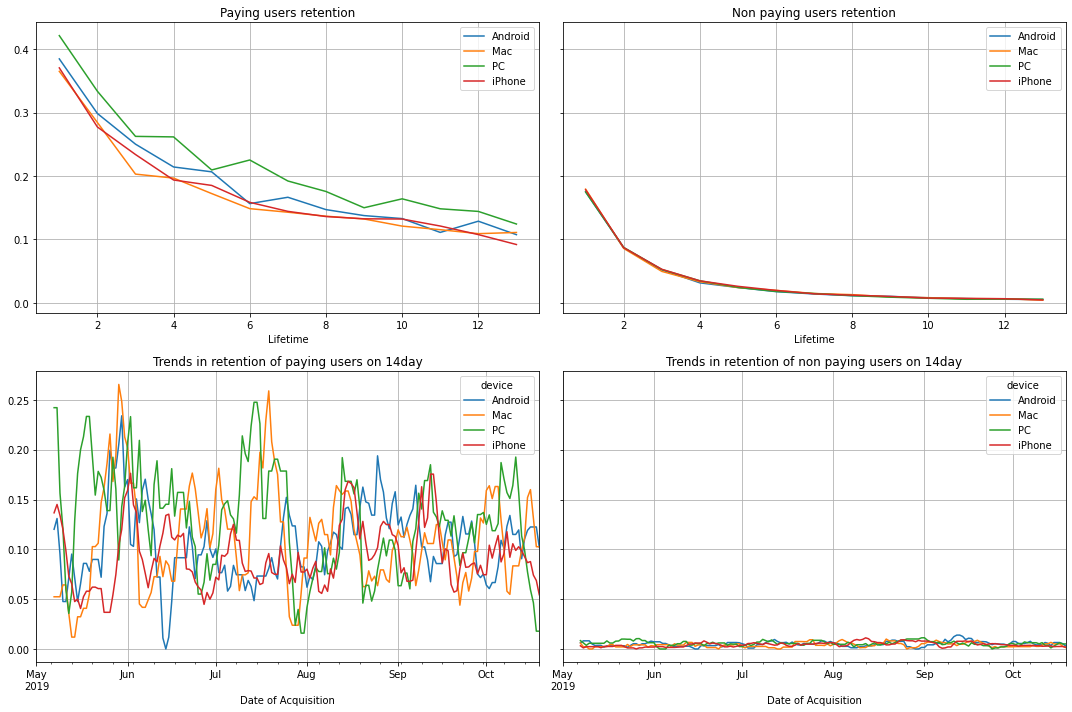

In [42]:
# lets see retention by device
dimensions=['device']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_wo, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

PC users are harder to attract, but stay longer and retain the best.

### Analyse ROI and LTV on advertising by regions

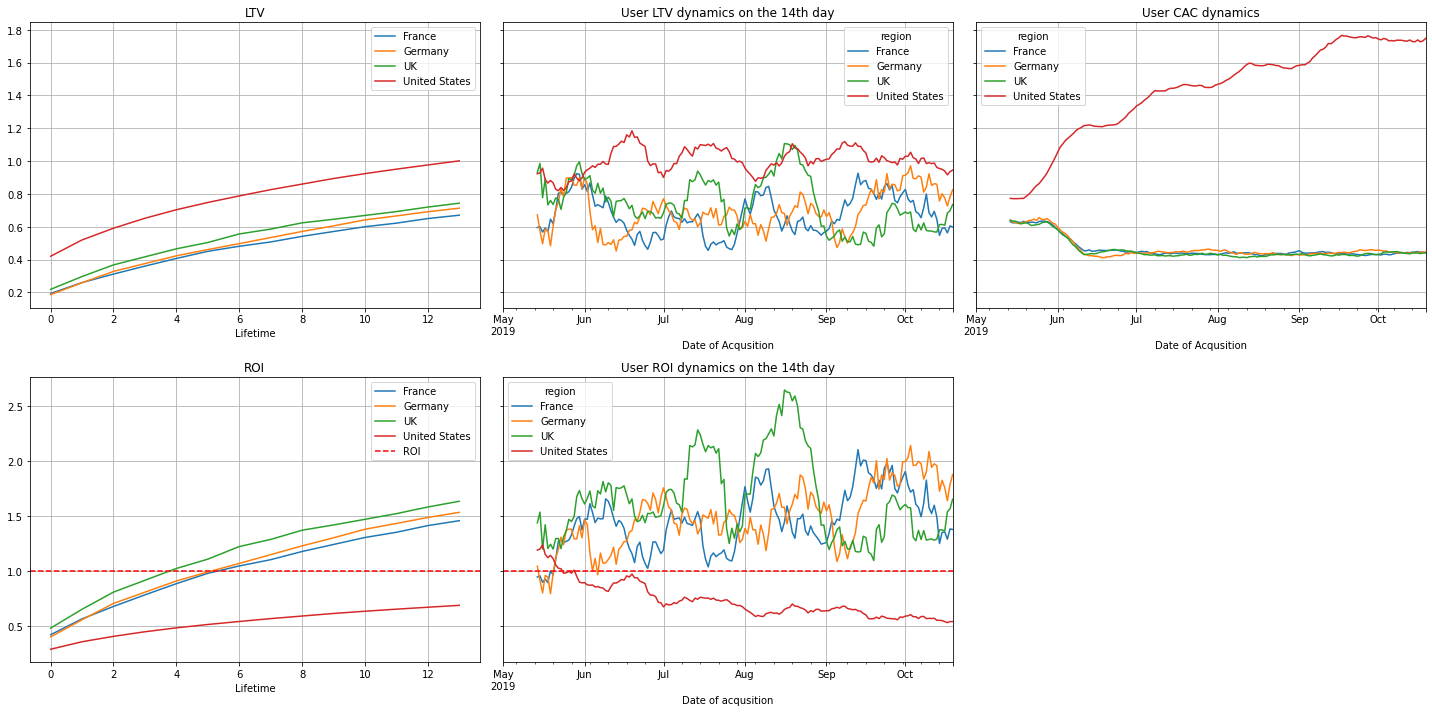

In [43]:
# lets see at ROI by regions

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

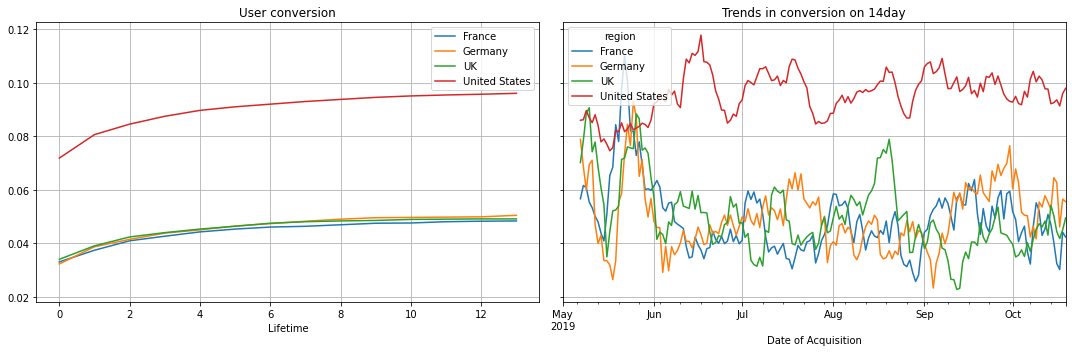

In [44]:
# lets see conversion rates by regions
dimensions=['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_wo, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

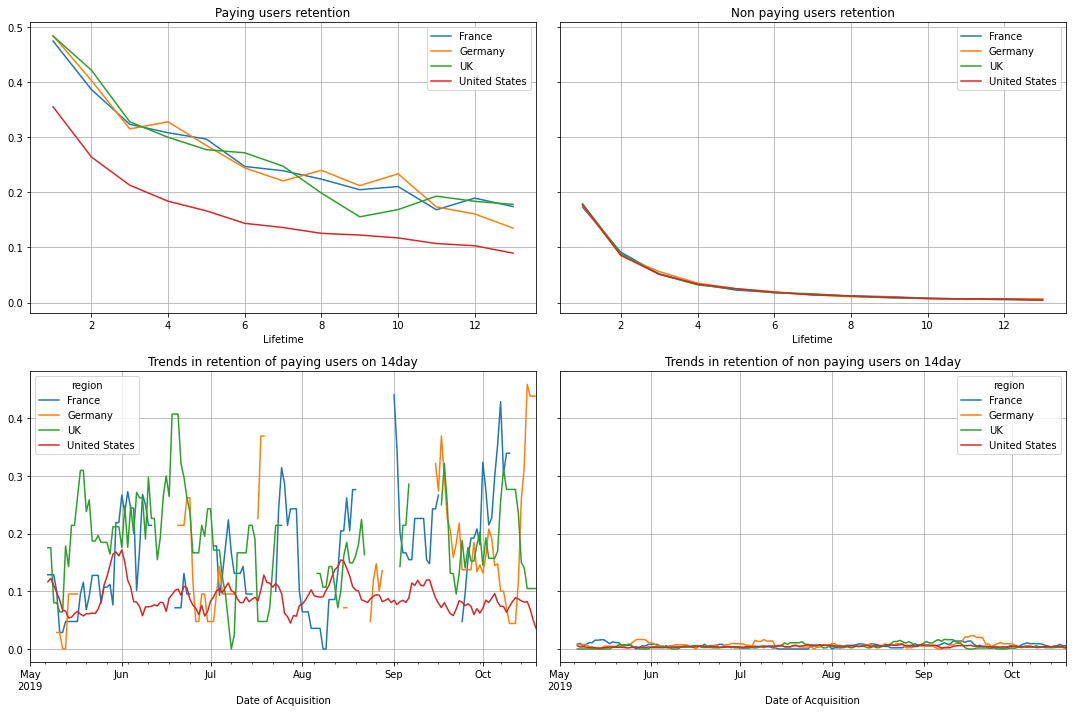

In [45]:
# lets see retention rates by regions
dimensions=['region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_wo, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Although the US has the highest conversion rate of all regions, it has the worst retention rate.
The USA also has the highest CAC, which is where we spend most of our advertising budgets. 
However, only in the USA the investment does not pay off (ROI is consistently less than 1)

### Analyse ROI and LTV on advertising by channels

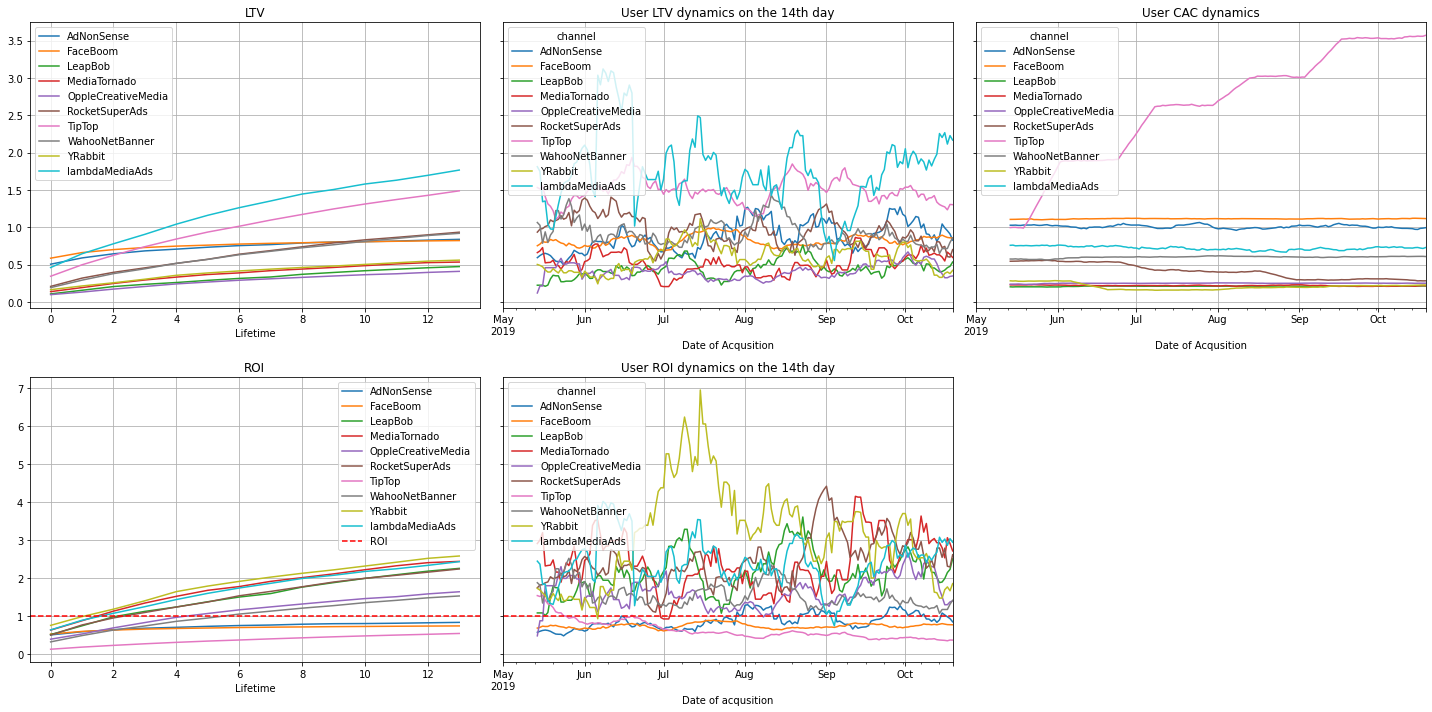

In [46]:
# lets see at ROI by channels

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

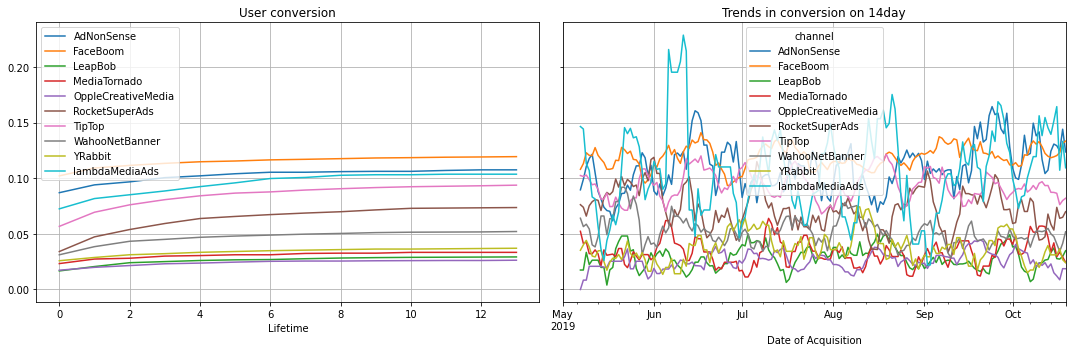

In [47]:
#  lets see conversion rates by channels
dimensions=['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_wo, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

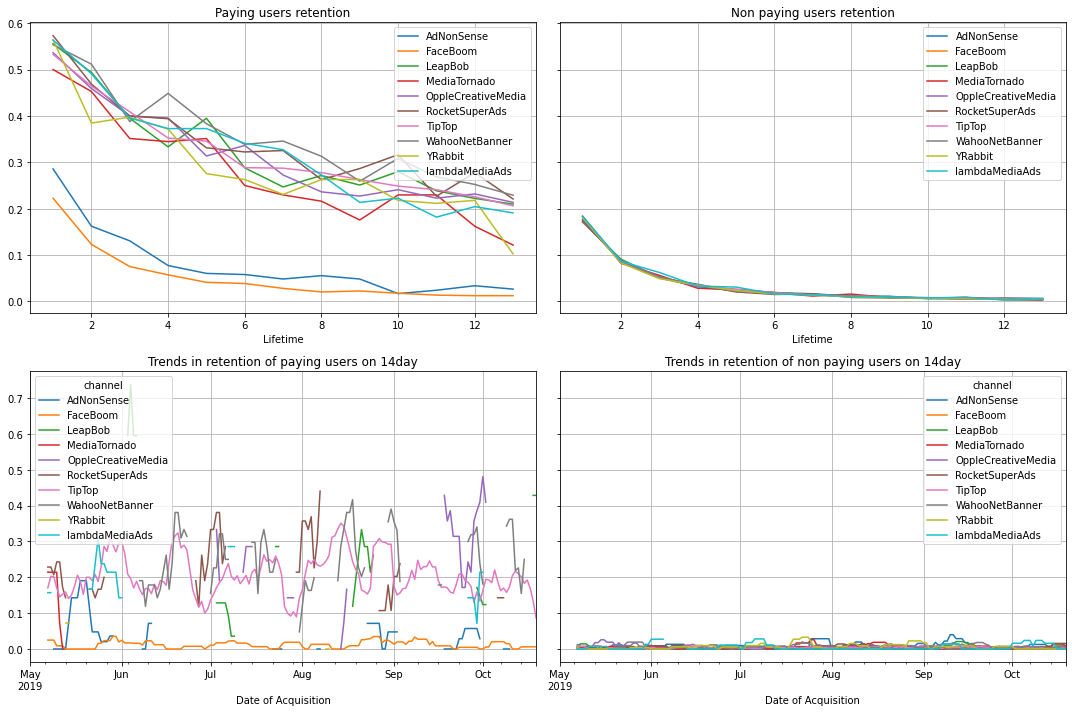

In [48]:
#  lets see retention rates by channels
dimensions=['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_wo, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

A very large part of the advertising budgets goes to TipTop and is growing every month, which also increases CAC.
Consequently, TipTop as well as FaceBoom and AdNOnsence have no return on investment and the ROI does not exceed 1.
    For FaceBoom and AdNOnsence users this is due to an abnormal drop in the retention rate already in the first days of the lifetime.

<a id='conc'></a>
# 6. Conclusions 


   1. The reasons for the inefficiency in attracting users is that advertising costs are going up, but there is no return on investment. The graphs clearly show the growth of CPC and monthly investment in advertising, but the problem is that we attract the same number of users each month, while 1/3 of all our users come to us organically. Therefore the ROI falls and the project loses money. In first 2 months of the project on 14th day of LightTime ROI was more than 1, when investments in ads was not so high, but in July the ROI is going down. In the same social network TipTop in the beginning the investment in advertising paid off, but with the growth of investment - stopped. Users from the network Faceboom did not pay off in any period of time due to low retention (from the graph conversion rate shows that they have the highest percentage of conversion. Users who came from AdnonSEnce can also be attributed there. It may also include, huge budgets to attract users from the USA, as a result: through advertising we produce new users, but they do not stay with us and quickly leave (users from the U.S. are the worst in retention rates, as seen in the retention chart).
   
   
   2. We need to think about reformatting and focusing on the European market, it is possible that on the US market there are already worthy competitors of our application, and our users "flow away" to them. In European markets our customers are better retained, but they are also leaving, a bit more slowly. Maybe the marketing department and developers should check our application and understand what the reason is and why users stop using it. Also, we need to significantly reduce investment in advertising on FB and TipTop and instead direct this money to other channels with lower CAC, for example -LambdaMediaAds, Yrabbit MediaTornado.